In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import norm
import statsmodels.api as sm
import re
import calendar

import matplotlib.pyplot as plt
import seaborn as sns

import copy

%matplotlib inline
%load_ext autotime

time: 363 µs (started: 2022-11-01 17:06:27 -04:00)


In [2]:
# Enrollment numbers
# https://infohub.nyced.org/reports/school-quality/information-and-data-overview
enrollment_count = {
    2017: 1135334,
    2018: 1126501,
    2019: 1131868,
    2020: 1094138,
    2021: 1058888,
    2022: 1030000 #This is an estimate that should be filled in.
}

time: 543 µs (started: 2022-11-01 17:06:27 -04:00)


In [3]:
pull_from_api = False
if (pull_from_api):
    data_orig = pd.read_json("https://data.cityofnewyork.us/resource/ez4e-fazm.json?$limit=99999999")
    data_orig['occurred_on'] = pd.to_datetime(data_orig['occurred_on'])
else:
    data_orig = pd.read_csv("../data/input/raw/Bus_Breakdown_and_Delays.csv", parse_dates = [7])

/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_49209/3086854128.py:6: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data_orig = pd.read_csv("../data/input/raw/Bus_Breakdown_and_Delays.csv", parse_dates = [7])


time: 21.9 s (started: 2022-11-01 17:06:27 -04:00)


In [4]:
def clean_delay_times_old(x):
    
    if  not any(i.isdigit for i in x): # Filter trivial cases with no numbers.
        return np.nan
    
    if ('h' in x) or ('H' in x):
        return 60.0
    
    nondigits = []
    
    for i in x:
        if not i.isdigit():
            nondigits.append(i)

    for i in nondigits:
        x = x.replace(i, ',')
    
    x = x.split(',')

    for i in x:
        if len(i) > 0 and int(i) < 300.:
            return int(i)
        else:
            return np.nan

time: 813 µs (started: 2022-11-01 17:06:49 -04:00)


In [5]:
def clean_delay_times(x):
    a = x
    x = str(x).lower().rstrip().replace('1 1/2', '1 2').replace('11/2', '1 2').\
    replace('1/2', '0 1').replace('half', '0 1').replace('to', '-')
    units = re.findall(r'[a-z ]+', x)
    time = re.split(r'[- /,]', ''.join(re.findall(r'[0-9 .,/-]+', x)) )
    time = [i for i in time if not((re.search('[.]+',i) !=None)|(re.search('[ ]+',i) !=None)|(i==''))]
    if time:
        time = np.nanmean([float(i) for i in time])
    else:
        time = 0
    
    if any(i in ''.join(units) for i in ['h', 'r']) and ( time <= 5 ):
#         print(a)
#         print(time*60)
        return time*60
    elif any(i in ''.join(units) for i in ['m', 'n']) | (x == ''):
        return time
    else:
#         print(a)
#         print(time, units)
        return 0

time: 2.52 ms (started: 2022-11-01 17:06:49 -04:00)


In [6]:
# Drop the 2020 data point
# data_orig.drop(data_orig[data_orig['School_Year'] == '2019-2020'].index, inplace = True)
data_orig['delay_time'] = data_orig.How_Long_Delayed.astype(str).apply(clean_delay_times)
# Only can normalize from 2017 forth.
data_orig = data_orig[data_orig['Occurred_On'] > pd.to_datetime('08-31-2017')]

time: 22.6 s (started: 2022-11-01 17:06:49 -04:00)


In [7]:
data = copy.deepcopy(data_orig)

time: 46.2 ms (started: 2022-11-01 17:07:12 -04:00)


In [8]:
def school_year(year, month):
    if month < 9:
        return year - 1
    else: 
        return year

time: 435 µs (started: 2022-11-01 17:07:12 -04:00)


In [9]:
num_delays_threshold = 200

data_monthly = data.groupby([data['Occurred_On'].dt.year, data['Occurred_On'].dt.month,
              data['Occurred_On'].dt.day]).count()
data_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
data_monthly.drop(data_monthly[data_monthly['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
days_per_month = data_monthly.groupby(level = ['Year', 'Month']).count()[['School_Year']]
data_monthly = data_monthly.groupby(level = ['Year', 'Month']).sum()[['School_Year']]
data_monthly['days_per_month'] = days_per_month
data_monthly['schl_yr'] = [school_year(i, j) for i, j in zip(data_monthly.index.get_level_values(0), 
                                                             data_monthly.index.get_level_values(1))]
# multiply delay frequency by enrollment count in 2022/enrollment count in respective year to normalize for changing school population
data_monthly['School_Year'] = data_monthly['School_Year']*enrollment_count[2022]/data_monthly['schl_yr'].apply(lambda x: enrollment_count[x])

#### Remove days that are not expected to be school days (below delay threshold) from data ####


data_heavy_traffic = data[data.Reason == 'Heavy Traffic']
data_accident = data[data.Reason == 'Accident']
data_problematic = data[data.Reason == 'Problem Run']
data_preventable_delay = data[(data.Reason == 'Mechanical Problem') | (data.Reason == 'Won`t Start') |
                             (data.Reason == 'Flat Tire')]# Call these "Automotive" not "Preventable Delays"

heavy_traffic_monthly = data_heavy_traffic.groupby([data_heavy_traffic['Occurred_On'].dt.year, data_heavy_traffic['Occurred_On'].dt.month, data_heavy_traffic['Occurred_On'].dt.day])[['School_Year']].count()
heavy_traffic_monthly.drop(data_monthly[data_monthly['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
heavy_traffic_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
heavy_traffic_monthly = heavy_traffic_monthly.groupby(level = ['Year', 'Month']).sum()

preventable_delay_monthly = data_preventable_delay.groupby([data_preventable_delay['Occurred_On'].dt.year, data_preventable_delay['Occurred_On'].dt.month, data_preventable_delay['Occurred_On'].dt.day])[['School_Year']].count()
preventable_delay_monthly.drop(data_monthly[data_monthly['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
preventable_delay_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
preventable_delay_monthly = preventable_delay_monthly.groupby(level = ['Year', 'Month']).sum()

accidents_monthly = data_accident.groupby([data_accident['Occurred_On'].dt.year, data_accident['Occurred_On'].dt.month, data_accident['Occurred_On'].dt.day])[['School_Year']].count()
accidents_monthly.drop(data_monthly[data_monthly['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
accidents_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
accidents_monthly = accidents_monthly.groupby(level = ['Year', 'Month']).sum()

problematic_monthly = data_problematic.groupby([data_problematic['Occurred_On'].dt.year, data_problematic['Occurred_On'].dt.month, data_problematic['Occurred_On'].dt.day])[['School_Year']].count()
problematic_monthly.drop(data_monthly[data_monthly['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
problematic_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
problematic_monthly = problematic_monthly.groupby(level = ['Year', 'Month']).sum()

data_monthly['labels'] = data_monthly.index.map(lambda x: str(calendar.month_abbr[x[1]]) + " " + str(x[0]) )
data_monthly['heavy_traffic'] = heavy_traffic_monthly['School_Year']
data_monthly['preventable_delay'] = preventable_delay_monthly['School_Year']
data_monthly['accident'] = accidents_monthly['School_Year']
data_monthly['problematic'] = problematic_monthly['School_Year']
# display(data_monthly)


# Getting number of days since Sep 1, 2015
data_monthly['date_time'] = data_monthly.index.map(lambda x: (pd.datetime(x[0], x[1], 1) 
        - pd.datetime(data_monthly.index[0][0], data_monthly.index[0][1], 1)).days )

# Drop nan days_per_month
data_monthly.dropna(inplace = True)

# Get normalized delay frequency
data_monthly['normalized_delay_frequency'] = data_monthly['School_Year']/data_monthly['days_per_month']
data_monthly['normalized_heavy_traffic'] = data_monthly['heavy_traffic']/data_monthly['days_per_month']
data_monthly['normalized_preventable_delay'] = data_monthly['preventable_delay']/data_monthly['days_per_month']
data_monthly['normalized_accident'] = data_monthly['accident']/data_monthly['days_per_month']
data_monthly['normalized_problematic'] = data_monthly['problematic']/data_monthly['days_per_month']

# Change column name
data_monthly.rename(columns = {'School_Year': 'delay_frequency'}, inplace = True)

# Make labels and ticks for plotting
ticks = copy.deepcopy(data_monthly['date_time'])
labels = copy.deepcopy(data_monthly['labels'])

time: 1.11 s (started: 2022-11-01 17:07:12 -04:00)


/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_49209/3438425519.py:53: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  data_monthly['date_time'] = data_monthly.index.map(lambda x: (pd.datetime(x[0], x[1], 1)
/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_49209/3438425519.py:54: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  - pd.datetime(data_monthly.index[0][0], data_monthly.index[0][1], 1)).days )


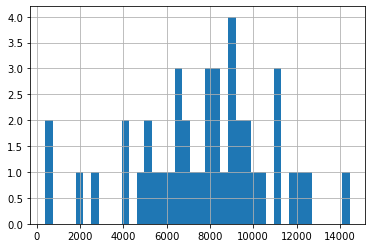

time: 295 ms (started: 2022-11-01 17:07:13 -04:00)


In [10]:
data_monthly['delay_frequency'].hist(bins = 40)

In [11]:
alpha = 1

X_train = np.array(data_monthly['date_time']).reshape(-1, 1)
y_train = np.array(data_monthly['normalized_heavy_traffic']).reshape(-1, 1)

from sklearn.linear_model import LinearRegression, Ridge, Lasso

lrm = Ridge(alpha = alpha)

lrm.fit(X_train, y_train)

data_monthly['regression_fit_heavy'] = lrm.predict(X_train)

X_train = np.array(data_monthly['date_time']).reshape(-1, 1)
y_train = np.array(data_monthly['normalized_preventable_delay']).reshape(-1, 1)

lrm = Ridge(alpha = alpha)

lrm.fit(X_train, y_train)

data_monthly['regression_fit_preventable'] = lrm.predict(X_train)

X_train = np.array(data_monthly['date_time']).reshape(-1, 1)
y_train = np.array(data_monthly['normalized_accident']).reshape(-1, 1)

lrm = Ridge(alpha = alpha)

lrm.fit(X_train, y_train)

data_monthly['regression_fit_accident'] = lrm.predict(X_train)


X_train = np.array(data_monthly['date_time']).reshape(-1, 1)
y_train = np.array(data_monthly['normalized_problematic']).reshape(-1, 1)

lrm = Ridge(alpha = alpha)

lrm.fit(X_train, y_train)

data_monthly['regression_fit_problematic'] = lrm.predict(X_train)

time: 115 ms (started: 2022-11-01 17:07:13 -04:00)


Text(0, 0.5, 'Average number of delays per day')

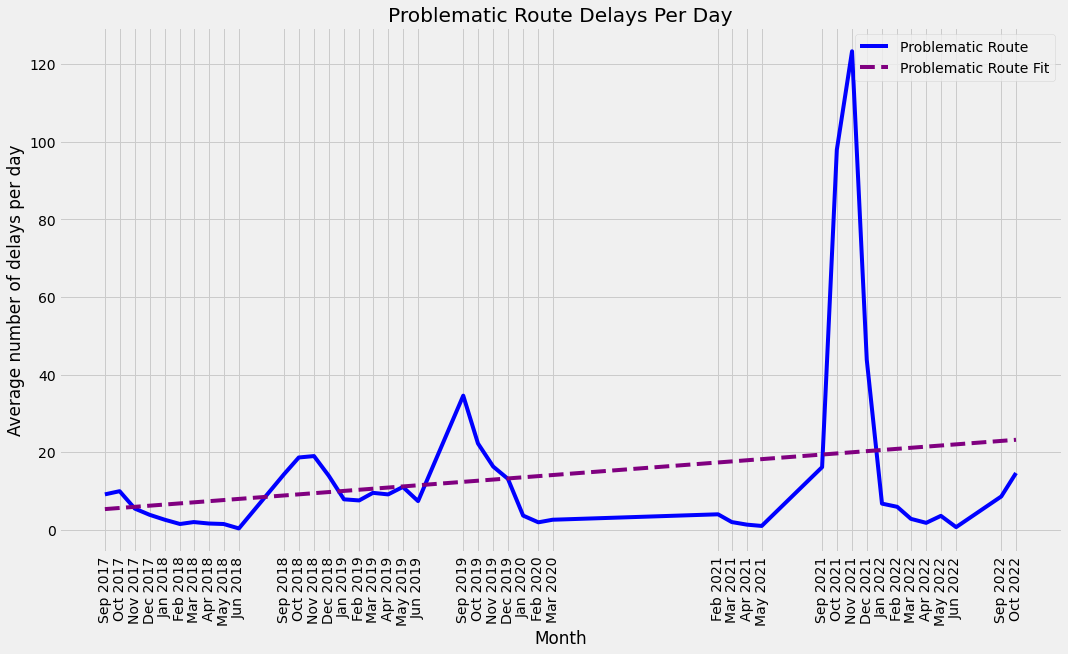

time: 440 ms (started: 2022-11-01 17:07:13 -04:00)


In [12]:
plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('fivethirtyeight')
plt.plot(data_monthly['date_time'], data_monthly['normalized_problematic'], label = 'Problematic Route', color = 'b')
plt.plot(data_monthly['date_time'], data_monthly['regression_fit_problematic'], label = 'Problematic Route Fit', linestyle = '--', color = 'purple')

# plt.plot(data_monthly['date_time'], data_monthly['regression_fit_heavy'] + data_monthly['normalized_heavy_traffic'].std(), label = "", linestyle = ':', color = 'purple')
# plt.plot(data_monthly['date_time'], data_monthly['regression_fit_heavy'] - data_monthly['normalized_heavy_traffic'].std(), label = "", linestyle = ':', color = 'purple')

# plt.plot(data_monthly['date_time'], data_monthly['normalized_preventable_delay'], label = 'Preventable* Delays', color = 'r')
# plt.plot(data_monthly['date_time'], regression_fit_preventable, label = 'Preventable Delay Fit ± std', linestyle = '--', color = 'pink')
# plt.plot(data_monthly['date_time'], regression_fit_preventable + data_monthly['normalized_preventable_delay'].std(), linestyle = ':', color = 'pink')
# plt.plot(data_monthly['date_time'], regression_fit_preventable - data_monthly['normalized_preventable_delay'].std(), linestyle = ':', color = 'pink')
# plt.plot(preventable_delay_monthly['Month'] , preventable_delay_monthly['School_Year'], label = 'All Delays')


plt.xticks(ticks, labels, rotation='vertical')
legend = plt.legend()
plt.setp(legend.get_texts(), color='Black')
plt.title("Problematic Route Delays Per Day", color = 'Black')
plt.xlabel("Month")
plt.ylabel("Average number of delays per day")

Text(0, 0.5, 'Average number of delays per day')

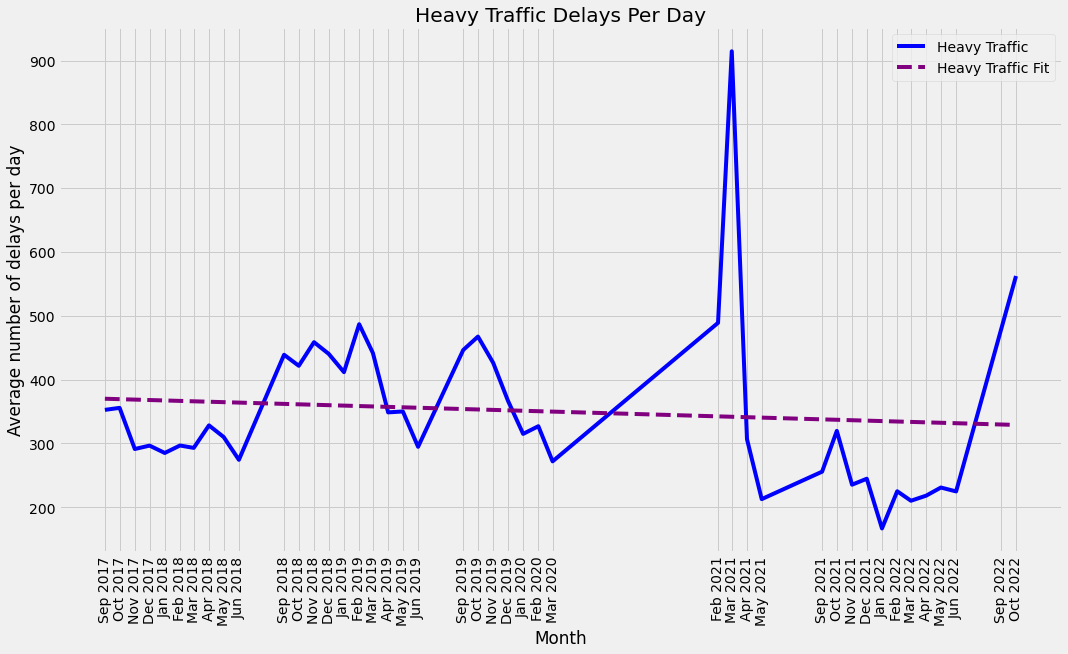

time: 385 ms (started: 2022-11-01 17:07:14 -04:00)


In [13]:
plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('fivethirtyeight')
plt.plot(data_monthly['date_time'], data_monthly['normalized_heavy_traffic'], label = 'Heavy Traffic', color = 'b')
plt.plot(data_monthly['date_time'], data_monthly['regression_fit_heavy'], label = 'Heavy Traffic Fit', linestyle = '--', color = 'purple')


plt.xticks(ticks, labels, rotation='vertical')
legend = plt.legend()
plt.setp(legend.get_texts(), color='Black')
plt.title("Heavy Traffic Delays Per Day", color = 'Black')
plt.xlabel("Month")
plt.ylabel("Average number of delays per day")

Text(0, 0.5, 'Average number of delays per day')

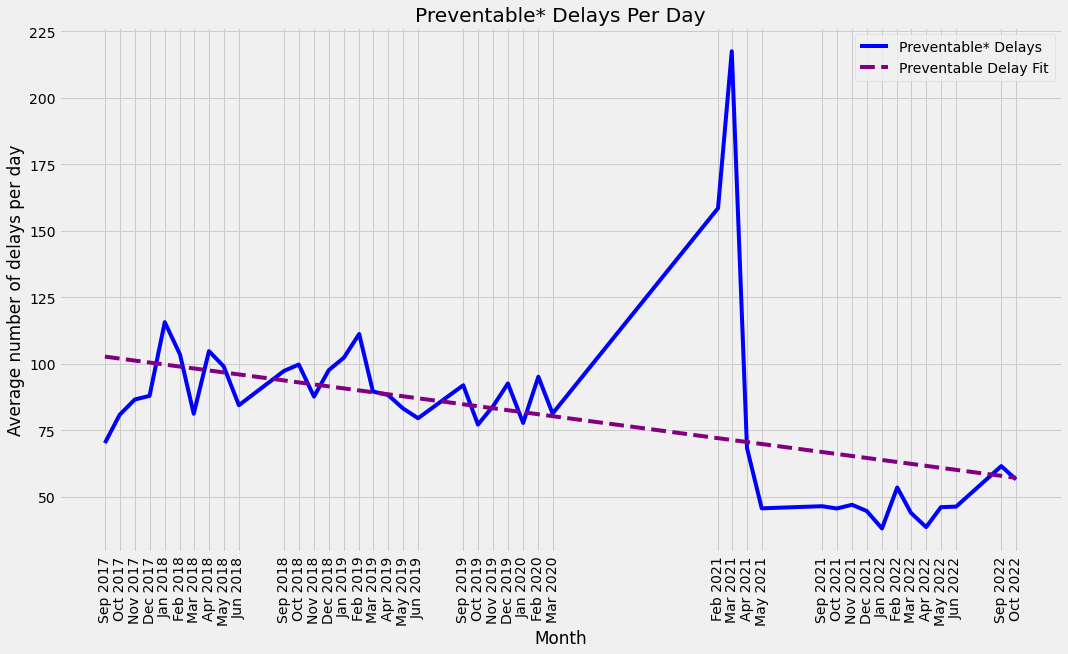

time: 417 ms (started: 2022-11-01 17:07:14 -04:00)


In [14]:
plt.plot(data_monthly['date_time'], data_monthly['normalized_preventable_delay'], label = 'Preventable* Delays', color = 'b')
plt.plot(data_monthly['date_time'], data_monthly['regression_fit_preventable'], label = 'Preventable Delay Fit', linestyle = '--', color = 'purple')

plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('fivethirtyeight')
plt.xticks(ticks, labels, rotation='vertical')
legend = plt.legend()
plt.setp(legend.get_texts(), color='Black')
plt.title("Preventable* Delays Per Day", color = 'Black')
plt.xlabel("Month")
plt.ylabel("Average number of delays per day")

Text(0, 0.5, 'Average number of accidents per day')

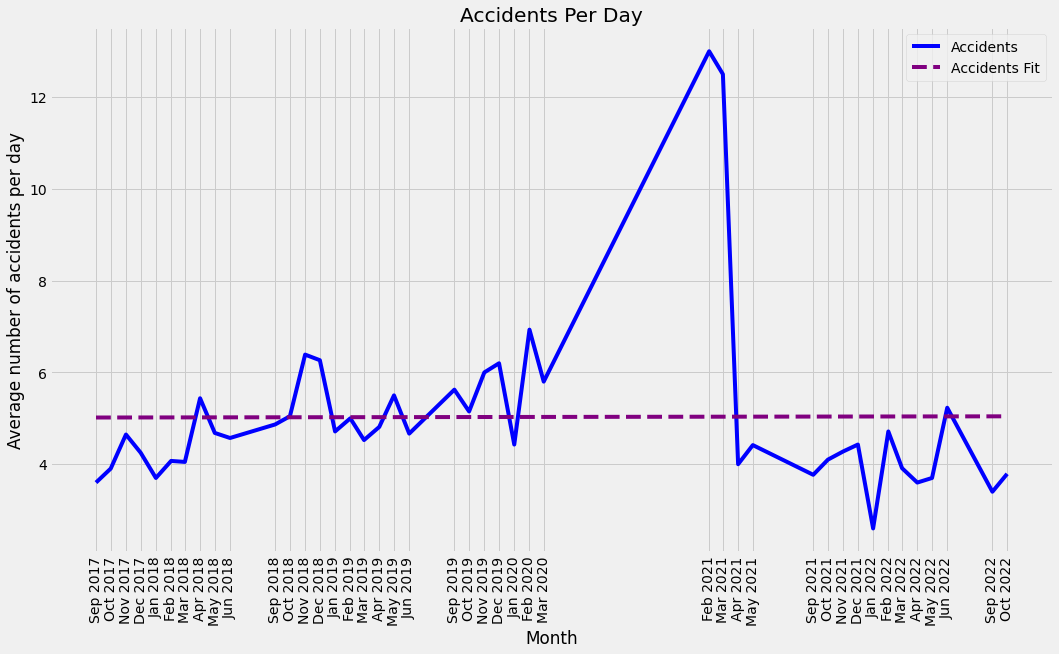

time: 517 ms (started: 2022-11-01 17:07:15 -04:00)


In [15]:
plt.plot(data_monthly['date_time'], data_monthly['normalized_accident'], label = 'Accidents', color = 'b')
plt.plot(data_monthly['date_time'], data_monthly['regression_fit_accident'], label = 'Accidents Fit', linestyle = '--', color = 'purple')

plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('fivethirtyeight')
plt.xticks(ticks, labels, rotation='vertical')
legend = plt.legend()
plt.setp(legend.get_texts(), color='Black')
plt.title("Accidents Per Day", color = 'Black')
plt.xlabel("Month")
plt.ylabel("Average number of accidents per day")

In [16]:
data_g = data
data_g['Heavy_Traffic'] = [(x == 'Heavy Traffic') for x in data_g['Reason']]

data_g = data.groupby(['Boro', 'Reason']).count()
data_g = data_g[['School_Year']]
data_g.rename(columns = {'School_Year':'Number_delays'}, inplace = True)
data_g.drop('All Boroughs', level = 'Boro', inplace = True)

total = np.array(data_g.merge(data_g.groupby(level = 'Boro').sum()[['Number_delays']], on = 'Boro')['Number_delays_y'])
data_g['total'] = total

data_g['Percent'] = 100*data_g['Number_delays'].astype(float)/data_g['total'].astype(float)

data_g.drop(columns = 'total', inplace = True)

data_g.to_csv("reason_for_delay_by_borough.csv")

time: 883 ms (started: 2022-11-01 17:07:15 -04:00)


In [17]:
# Quick code to find out whether traffic delays are heavier in one borough vs another.
# Look at ratio of heavy traffic delays to non heavy traffic delays by borough.

data_g = data
data_g['Heavy_Traffic'] = [(x == 'Heavy Traffic') for x in data_g['Reason']]

data_g = data.groupby(['Boro', 'Reason']).count()
data_g = data_g[['School_Year']]
data_g.rename(columns = {'School_Year':'Number_delays'}, inplace = True)
data_g.drop('All Boroughs', level = 'Boro').to_csv("reason_for_delay_by_borough.csv")
# For a given Boro, divide the School_Year associated with Heavy_Traffic == True by the false.

time: 921 ms (started: 2022-11-01 17:07:16 -04:00)


In [18]:
# Look at delays by runtype and delay type.

df = pd.DataFrame()
for i in data['Run_Type'].unique():
    new_df = pd.DataFrame(data[data['Run_Type'] == i]['Reason'].value_counts()*100/len(data[data['Run_Type'] == i]))
    new_df['Run_Type'] = i
    new_df['Number_delays'] = data[data['Run_Type'] == i]['Reason'].value_counts()
    df = pd.concat([df, new_df])
#     print (i, "\n", data[data['Run_Type'] == i]['Reason'].value_counts()/len(data[data['Run_Type'] == i]), "\n")

df.rename(columns = {'Reason': 'Percent_delay'}, inplace = True)
# df
df.to_csv("delay_by_runtype_and_delaytype.csv")

time: 1.2 s (started: 2022-11-01 17:07:17 -04:00)


######################################################################################################

New Analysis for 2022

######################################################################################################

[None, None, None, None, None, None, None, None, None, None]

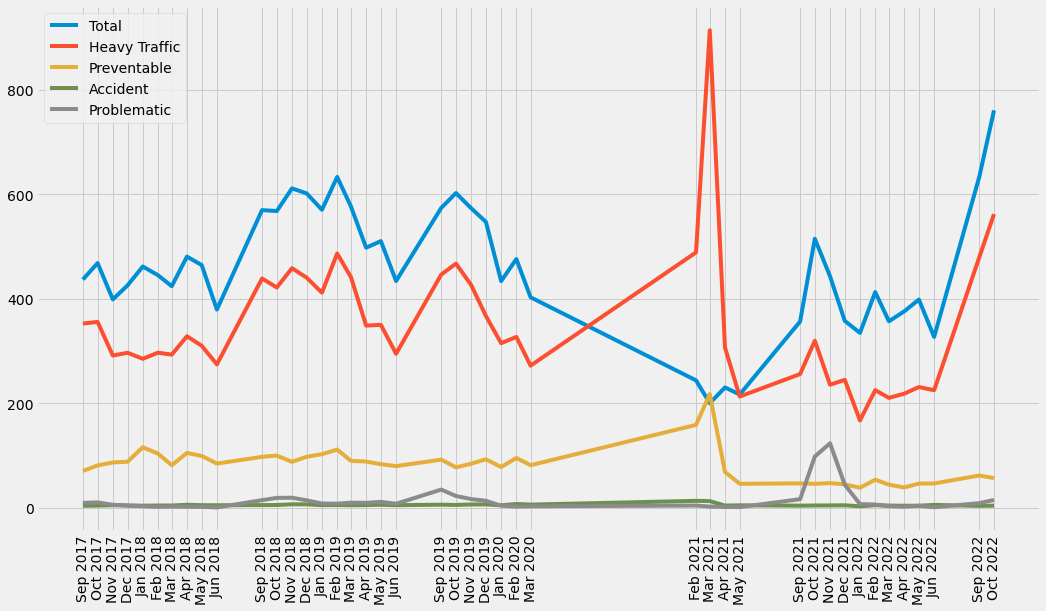

time: 420 ms (started: 2022-11-01 17:07:18 -04:00)


In [20]:
plt.plot(data_monthly['date_time'], data_monthly['normalized_delay_frequency'], label = "Total")
plt.plot(data_monthly['date_time'], data_monthly['normalized_heavy_traffic'], label = "Heavy Traffic")
plt.plot(data_monthly['date_time'], data_monthly['normalized_preventable_delay'], label = "Preventable")
plt.plot(data_monthly['date_time'], data_monthly['normalized_accident'], label = "Accident")
plt.plot(data_monthly['date_time'], data_monthly['normalized_problematic'], label = "Problematic")

plt.xticks(ticks, data_monthly['labels'], rotation='vertical');
legend = plt.legend()
plt.setp(legend.get_texts(), color='Black')

In [21]:
data['Reason'].value_counts()

Heavy Traffic                  240112
Other                           54231
Mechanical Problem              36400
Won`t Start                     10501
Problem Run                     10257
Flat Tire                        8651
Weather Conditions               5592
Late return from Field Trip      4581
Accident                         3394
Delayed by School                2337
Name: Reason, dtype: int64

time: 28.3 ms (started: 2022-11-01 17:07:19 -04:00)


In [22]:
data_monthly

delay_frequency  days_per_month  schl_yr    labels  heavy_traffic  \
Year Month                                                                      
2017 9          6555.586286              15     2017  Sep 2017           5290   
     10         9837.915539              21     2017  Oct 2017           7472   
     11         6780.577346              17     2017  Nov 2017           4953   
     12         6812.330116              16     2017  Dec 2017           4747   
2018 1          9239.149008              20     2017  Jan 2018           5703   
     2          6232.615248              14     2017  Feb 2018           4156   
     3          8484.340291              20     2017  Mar 2018           5862   
     4          7694.149915              16     2017  Apr 2018           5254   
     5         10223.484895              22     2017  May 2018           6823   
     6          5311.784902              14     2017  Jun 2018           3842   
     9          8549.952463              15     2018  Sep 2018           6585   
     10        12499.882379              22     2018  Oct 2018           9278   
     11        11009.515304              18     2018  Nov 2018           8257   
     12         9028.149997              15     2018  Dec 2018           6606   
2019 1         11982.368413              21     2018  Jan 2019           8648   
     2          8869.055598              14     2018  Feb 2019           6816   
     3         10963.798523              19     2018  Mar 2019           8392   
     4          7967.520668              16     2018  Apr 2019           5580   
     5         11232.613198              22     2018  May 2019           7704   
     6          6512.812683              15     2018  Jun 2019           4422   
     9          9187.361070              16     2019  Sep 2019           7144   
     10        12053.861404              20     2019  Oct 2019           9350   
     11         9749.741136              17     2019  Nov 2019           7248   
     12         8210.020957              15     2019  Dec 2019           5507   
2020 1          9112.741062              21     2019  Jan 2020           6616   
     2          7143.500832              15     2019  Feb 2020           4906   
     3          4029.480469              10     2019  Mar 2020           2720   
2021 2           487.635015               2     2020  Feb 2021            978   
     3           400.086644               2     2020  Mar 2021           1829   
     4          2071.978123               9     2020  Apr 2021           2761   
     5          2601.033873              12     2020  May 2021           2554   
     9          4635.003891              13     2021  Sep 2021           3326   
     10        10303.034882              20     2021  Oct 2021           6395   
     11         7976.292110              18     2021  Nov 2021           4238   
     12         5009.500533              14     2021  Dec 2021           3427   
2022 1          6694.249061              20     2021  Jan 2022           3338   
     2          5779.893624              14     2021  Feb 2022           3152   
     3          8211.689999              23     2021  Mar 2022           4837   
     4          5639.822153              15     2021  Apr 2022           3274   
     5          7972.401236              20     2021  May 2022           4620   
     6          4250.780064              13     2021  Jun 2022           2924   
     9          9504.000000              15     2022  Sep 2022           7195   
     10        14460.000000              19     2022  Oct 2022          10685   

            preventable_delay  accident  problematic  date_time  \
Year Month                                                        
2017 9                   1053        54        137.0          0   
     10                  1697        82        209.0         30   
     11                  1472        79         93.0         61   
     12                  1407  

time: 30.2 ms (started: 2022-11-01 17:07:19 -04:00)


In [43]:
# Sept-Oct 2022 delays /total /average daily /average duration

#Need to say that we are only counting school days.

sept_oct_2022_total_delays = data_monthly[(data_monthly.index.get_level_values(0) == 2022 ) & 
                                          (data_monthly.index.get_level_values(1).isin([9, 10]))][
    'delay_frequency'].sum()
sept_oct_2022_total_delays


# Average daily delays

sept_oct_2022_average_daily_delays = data_monthly[(data_monthly.index.get_level_values(0) == 2022 ) & 
                                          (data_monthly.index.get_level_values(1).isin([9, 10]))][
    'delay_frequency'].sum()/data_monthly[(data_monthly.index.get_level_values(0) == 2022 ) & 
                                          (data_monthly.index.get_level_values(1).isin([9, 10]))][
    'days_per_month'].sum()
sept_oct_2022_average_daily_delays

# Average duration

data_tmp = data.groupby([data['Occurred_On'].dt.year, data['Occurred_On'].dt.month,
              data['Occurred_On'].dt.day]).agg(['count', 'sum'])
data_tmp.index.set_names(['Year', 'Month', 'Day'], inplace = True)
data_tmp.drop(data_tmp[data_tmp['School_Year']['count'] < num_delays_threshold].index, axis = 0, inplace = True)
data_tmp=data_tmp[(data_tmp.index.get_level_values(0) == 2022 ) & 
                  (data_tmp.index.get_level_values(1).isin([9, 10]))]

sept_oct_2022_average_delay_duration = data_tmp['delay_time']['sum'].sum()/data_tmp['delay_time']['count'].sum()

/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_49209/3025602450.py:22: FutureWarning: ['Occurred_On', 'Incident_Number'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  data_tmp = data.groupby([data['Occurred_On'].dt.year, data['Occurred_On'].dt.month,


39.521407110666

time: 1.81 s (started: 2022-11-01 17:37:13 -04:00)
